In [443]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [188]:
countries = os.listdir('data')
country_csv = {}
for country in countries:
    country_csv[country] = pd.read_csv(f'data/{country}/concatenated.csv')

#### Visualizing Different leagues Distributions

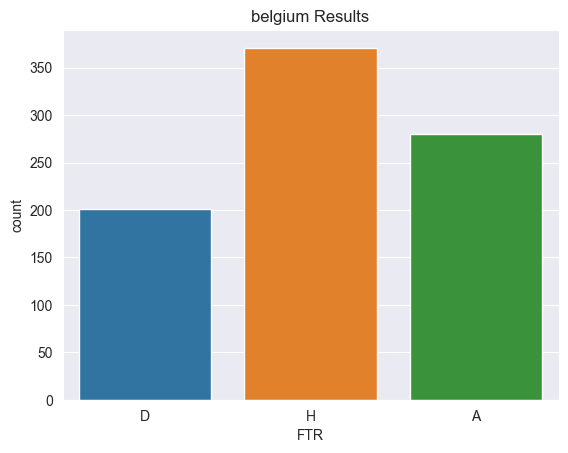

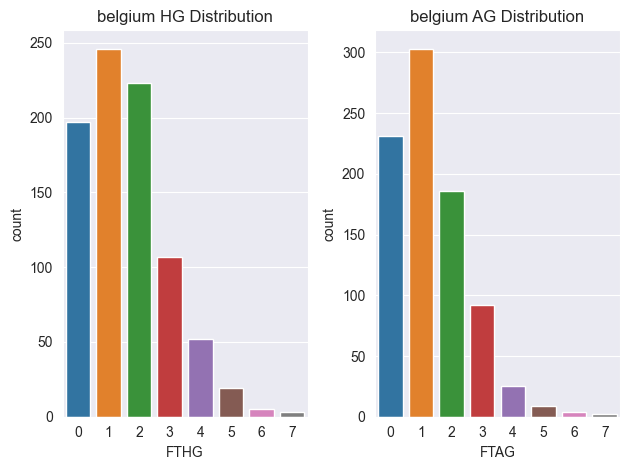

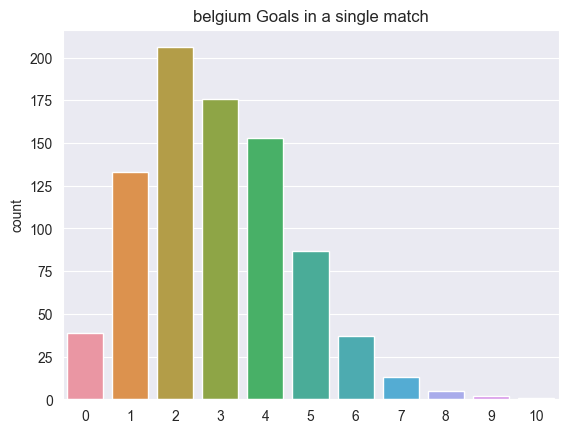

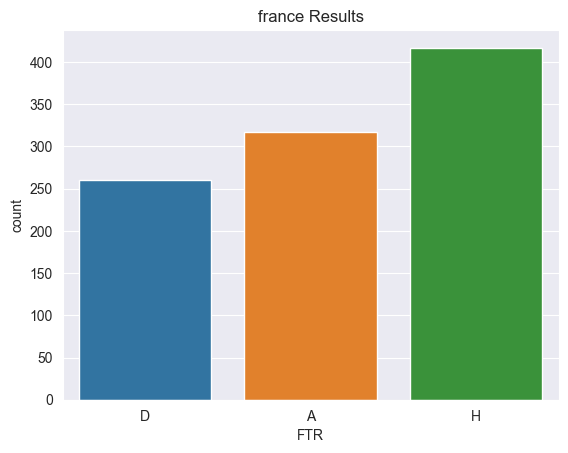

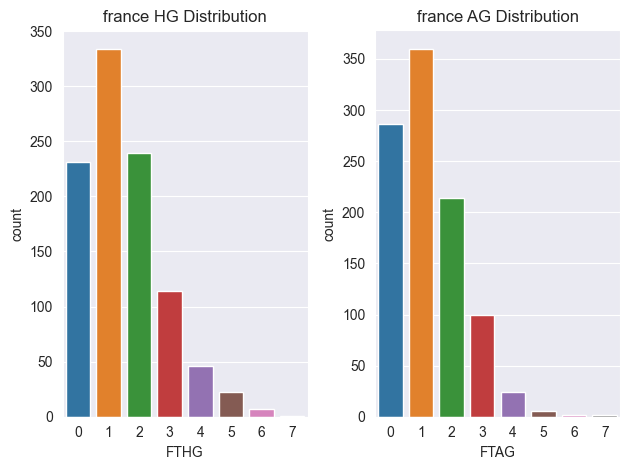

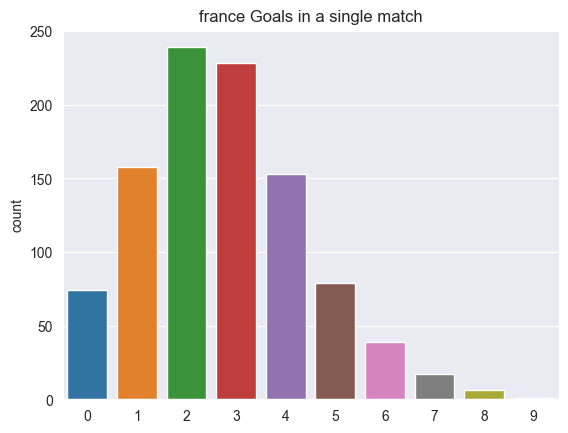

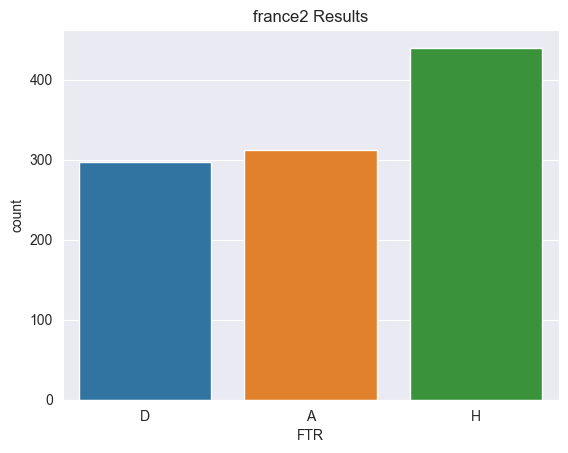

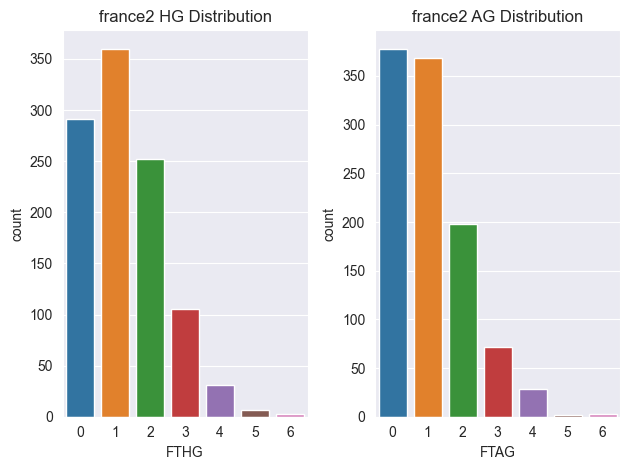

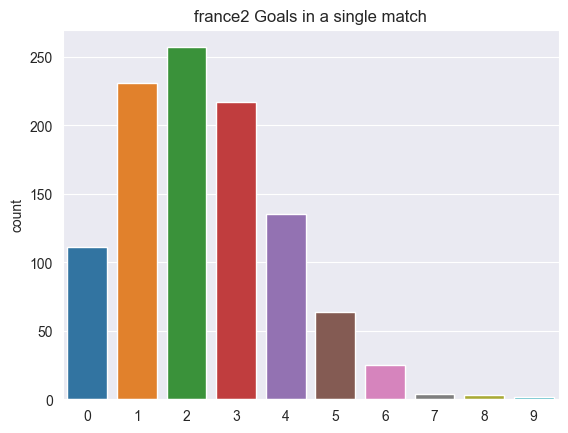

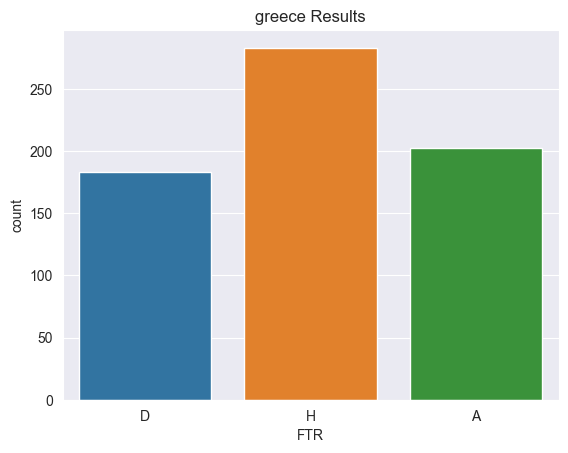

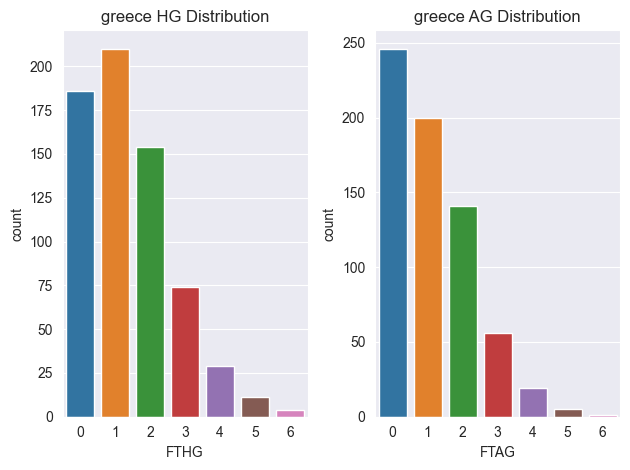

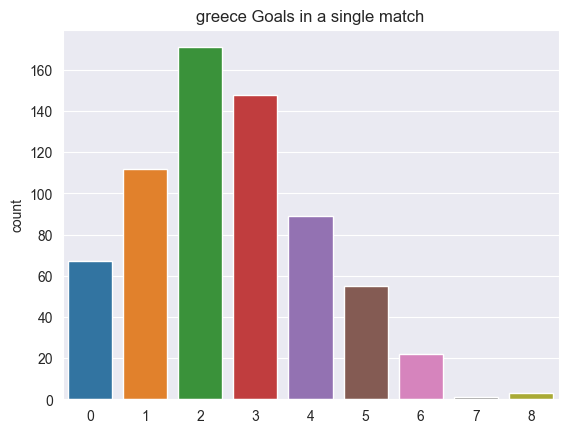

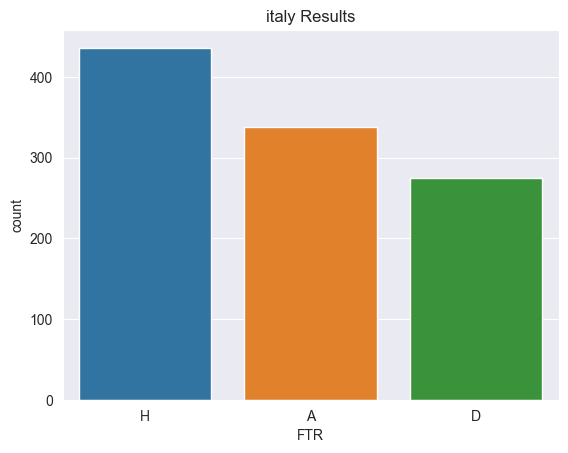

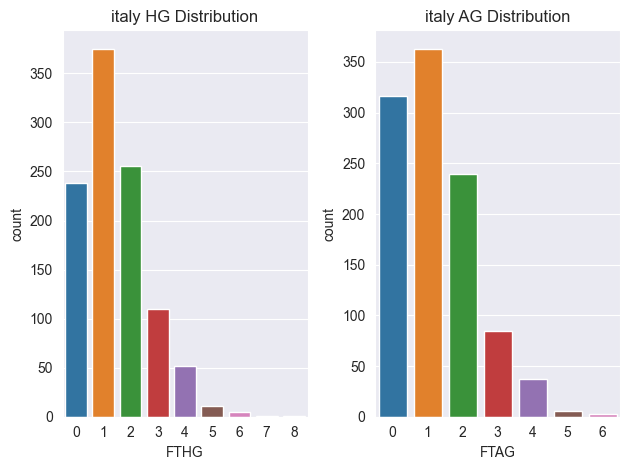

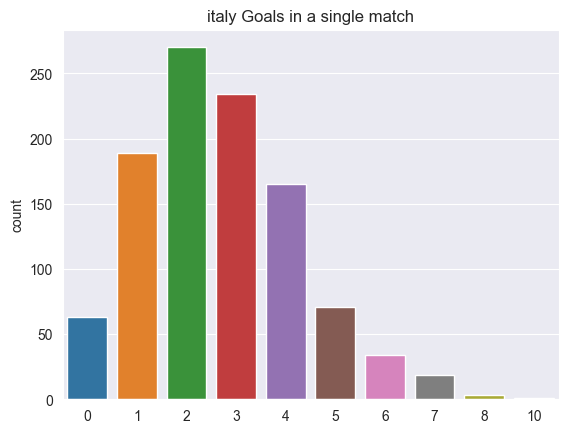

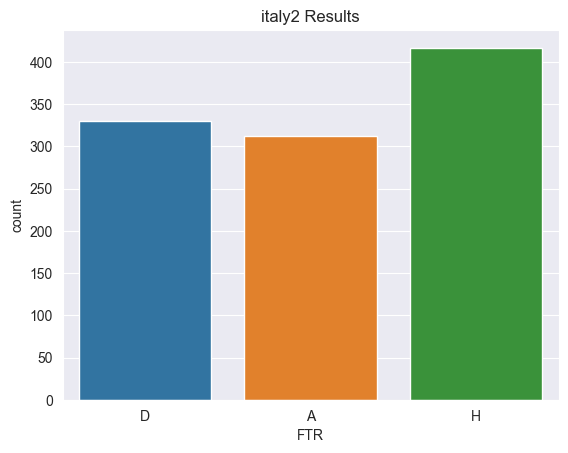

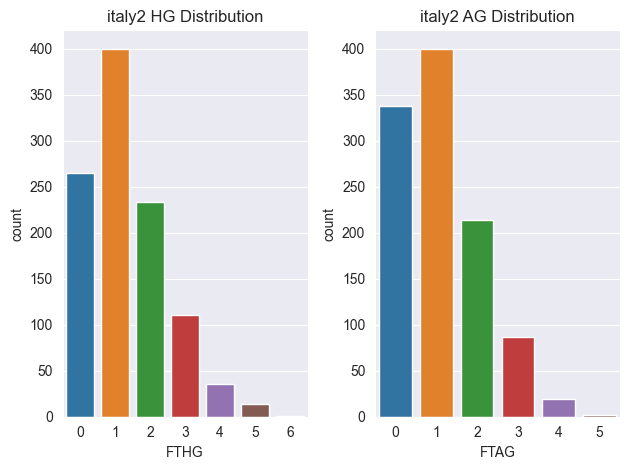

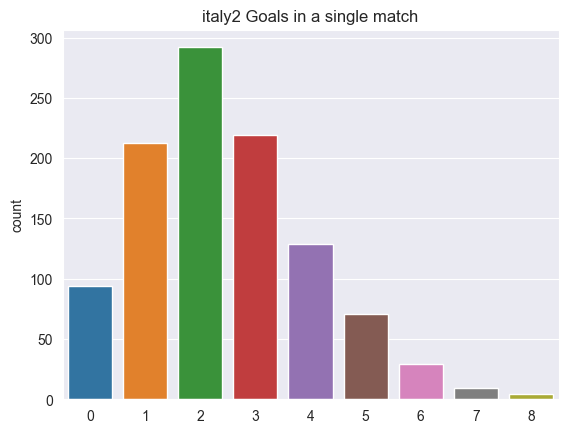

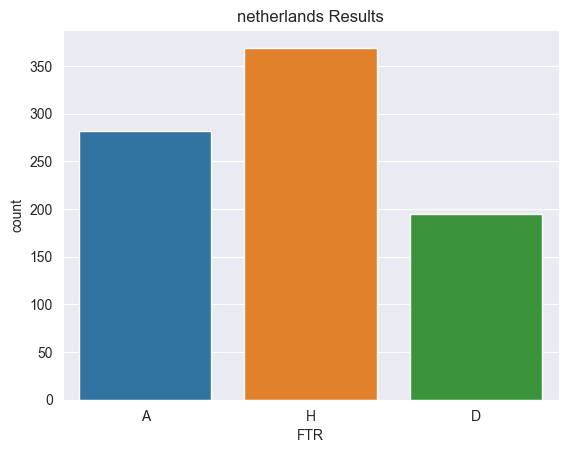

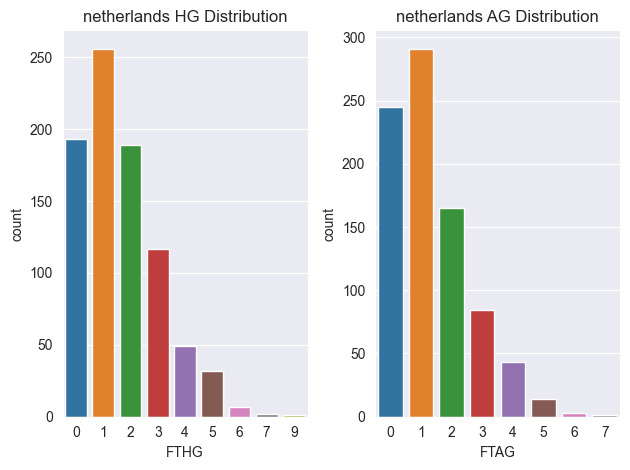

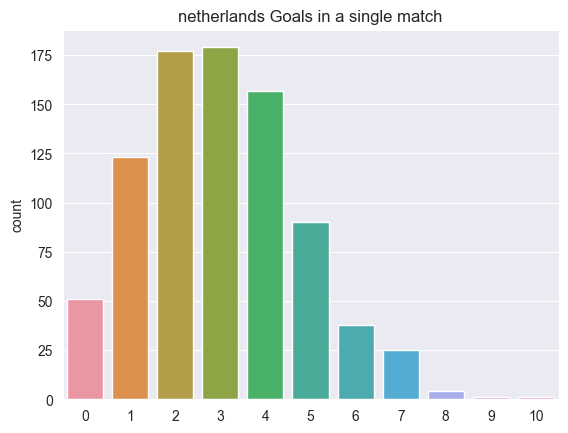

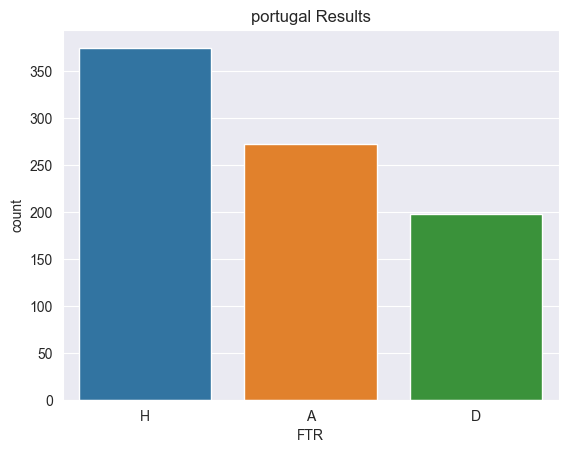

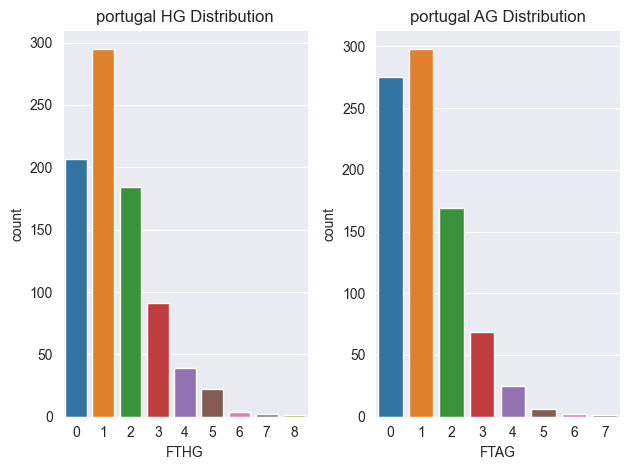

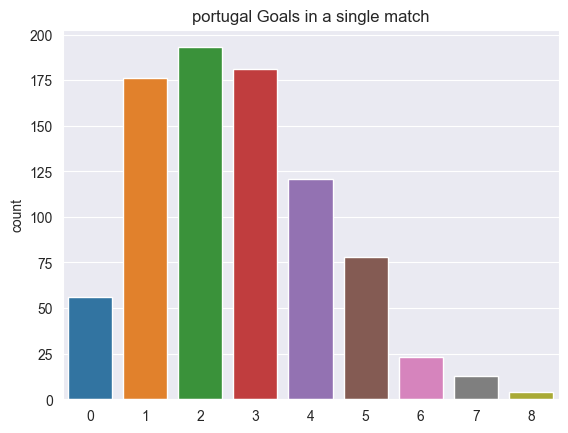

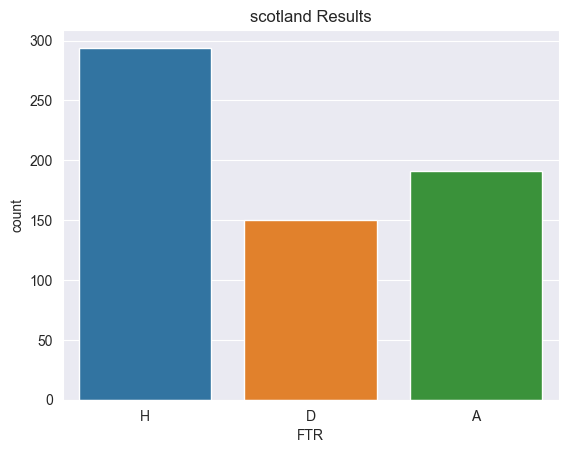

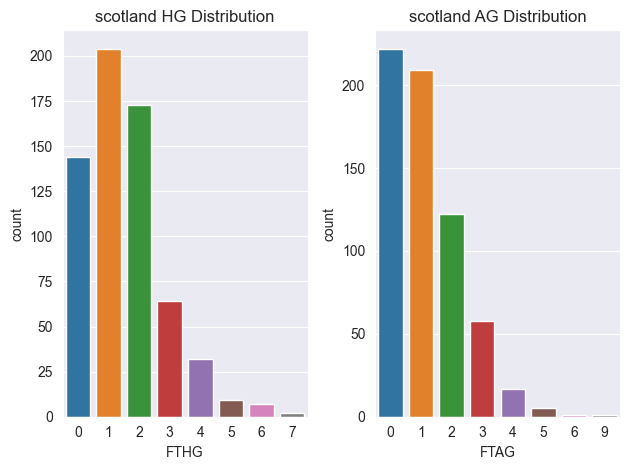

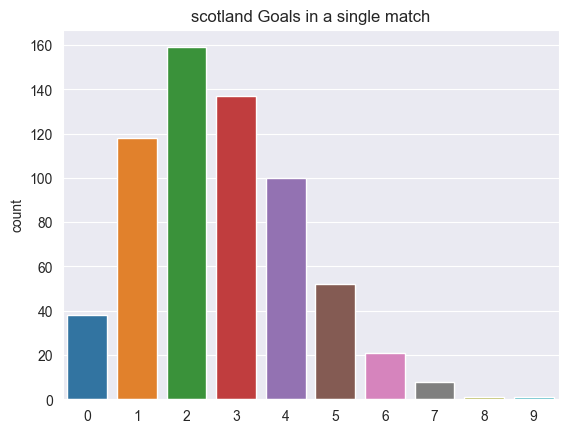

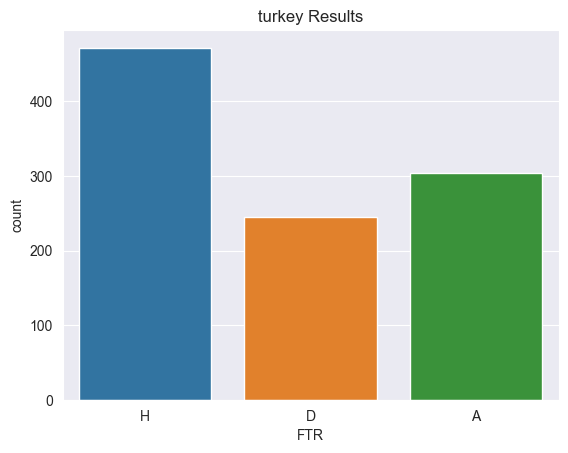

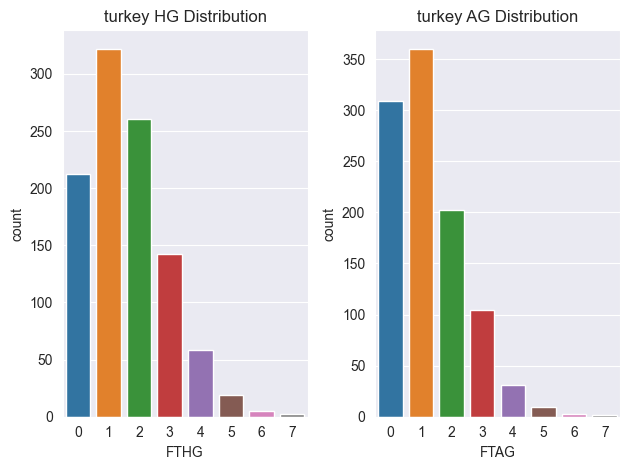

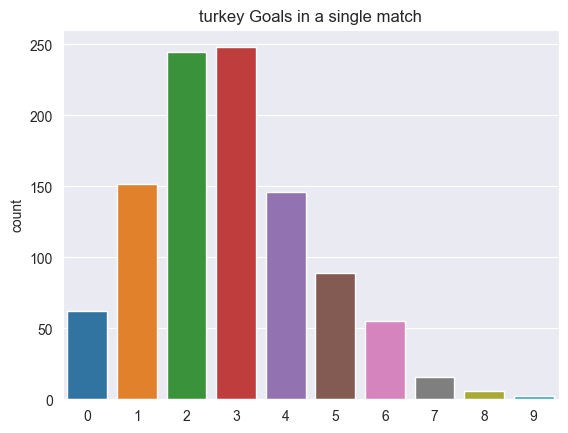

In [189]:
for country in countries:
    plt.figure()
    sns.countplot(x=country_csv[country]['FTR'])
    plt.title(f'{country} Results')
    plt.show()
    plt.figure()
    plt.subplot(1, 2, 1)
    sns.countplot(x='FTHG', data=country_csv[country])
    plt.title(f'{country} HG Distribution')

    plt.subplot(1, 2, 2)
    sns.countplot(x='FTAG', data=country_csv[country])
    plt.title(f'{country} AG Distribution')

    plt.tight_layout()
    plt.show()
    plt.figure()
    sns.countplot(x=(country_csv[country]['FTHG'] + country_csv[country]['FTAG']))
    plt.title(f'{country} Goals in a single match')
    plt.show()

In [290]:
considered_features = [
    'Date'
    , 'HomeTeam'
    , 'AwayTeam'
    , 'FTHG'
    , 'FTAG'
    , 'FTR'
    , 'HS'
    , 'AS'
    , 'HST'
    , 'AST'
    , 'HF'
    , 'AF'
    , 'HC'
    , 'AC'
    , 'HY'
    , 'AY'
    , 'HR'
    , 'AR']


In [415]:
example = pd.read_csv('data/france/2022_2023.csv')
example = example[considered_features]
example["Date"]= pd.to_datetime(example['Date'], format='%d/%m/%Y')

#### Extract Each team informations from the collected dataset

In [488]:
home_features = ['FTHG','FTR','FTAG','HS','HST','HF','HC','HY','HR']
away_features = ['FTAG','FTR','FTHG','AS','AST','AF','AC','AY','AR']
concat_features = ['match_id','day_nbr','goals','result','conceded_goals','Shots','ShotsOT','Fouls','Corners','YCard','RCard']
def teams_data_in_season(df):
    home_team_features = df.groupby('HomeTeam')
    away_team_features = df.groupby('AwayTeam')
    teams_data = {}
    for group_name, group_data in home_team_features:
       home_df = group_data.reset_index()[['index','Date'] + home_features]
       renamed = home_df.set_axis(concat_features, axis=1)
       renamed['result'] = renamed['result'].apply(lambda x:3 if x=='H' else (1 if x=='D' else 0))
       renamed['win'] = renamed['result'].apply(lambda x:1 if x==3 else 0)
       teams_data[group_name] = renamed
    for group_name, group_data in away_team_features:
       away_df = group_data.reset_index()[['index','Date'] + away_features].set_axis(concat_features, axis=1)
       away_df['result'] = away_df['result'].apply(lambda x:0 if x=='H' else (1 if x=='D' else 3))
       away_df['win'] = away_df['result'].apply(lambda x:1 if x==3 else 0)
       stacked = pd.concat([teams_data[group_name], away_df], axis=0)
       sorted = stacked.sort_values('match_id').reset_index(drop=True)
       sorted['Cards'] = (sorted['RCard']*3 +sorted['YCard']) / 4
       sorted.drop(['YCard','RCard'],axis=1,inplace=True)
       teams_data[group_name] = sorted
    return teams_data

#### Create the transformers of the data

In [489]:
def win_streak(col):
    streak = pd.Series([0] * col.size)
    current_streak = 0
    for i, value in enumerate(col):
        if value == 1:
            current_streak += 1
        else:
            current_streak = 0
        streak[i] = current_streak
    return streak



aggregate_features = ['goals','result','conceded_goals','Shots','ShotsOT','Fouls','Corners','Cards']
window = 5
relative_date = pd.to_datetime('1/1/2000')
def converter(df,rows_to_drop):
    converted = pd.DataFrame()
    row_indices = df.index + 1
    for col in aggregate_features:
      converted[f'{col}_last_{window}_matches'] = df[col].rolling(window=window, min_periods=1).mean()
      converted[f'{col}_overall'] = df[col].cumsum() / row_indices
    df['day_nbr'] = pd.to_datetime(df['day_nbr'], format='%d/%m/%Y')
    converted['rested_days'] = (df['day_nbr'] - relative_date).dt.days.diff()
    converted['win_percent'] = df['win'].cumsum() / row_indices
    converted['win_streak'] = win_streak(df['win'])
    final = converted[:-1]
    final['rested_days'] = converted['rested_days'][1:].tolist()
    final['match_id']= df['match_id'].iloc[1:].tolist()
    rows_to_drop.add(df['match_id'].iloc[0])
    return final

#### Extract The wanted information for each team

In [490]:
def teams_extract(teams_data):
    rows_to_drop = set()
    extracted_data = {}
    for team in teams_data.keys():
        extracted_data[team] = converter(teams_data[team],rows_to_drop)
    return extracted_data , rows_to_drop

#### Transformer of each season

In [491]:
def season_extracted(df):
    season_data = df.dropna()
    teams_data = teams_data_in_season(season_data)
    extracted_teams , todrop = teams_extract(teams_data)
    season_data = season_data.drop(list(todrop))
    return extracted_teams , season_data

In [492]:
extracted , season = season_extracted(example)

In [496]:
extracted['Paris SG']

,goals_last_5_matches,goals_overall,result_last_5_matches,result_overall,conceded_goals_last_5_matches,conceded_goals_overall,Shots_last_5_matches,Shots_overall,ShotsOT_last_5_matches,ShotsOT_overall,Fouls_last_5_matches,Fouls_overall,Corners_last_5_matches,Corners_overall,Cards_last_5_matches,Cards_overall,rested_days,win_percent,win_streak,match_id
0,5.000000,5.000000,3.0,3.000000,0.0,0.000000,18.0,18.000000,12.000000,12.000000,13.0,13.000000,6.00,6.000000,0.250000,0.250000,7.0,1.000000,1,12
1,5.000000,5.000000,3.0,3.000000,1.0,1.000000,19.0,19.000000,11.000000,11.000000,14.0,14.000000,8.50,8.500000,0.375000,0.375000,8.0,1.000000,2,28
2,5.666667,5.666667,3.0,3.000000,1.0,1.000000,18.0,18.000000,10.333333,10.333333,12.0,12.000000,7.00,7.000000,0.333333,0.333333,7.0,1.000000,3,38
3,4.500000,4.500000,2.5,2.500000,1.0,1.000000,18.0,18.000000,9.000000,9.000000,12.0,12.000000,6.25,6.250000,0.500000,0.500000,3.0,0.750000,0,48
4,4.200000,4.200000,2.6,2.600000,0.8,0.800000,18.4,18.400000,9.800000,9.800000,11.0,11.000000,6.80,6.800000,0.400000,0.400000,3.0,0.800000,1,51
5,3.800000,4.000000,2.6,2.666667,0.8,0.666667,18.6,18.500000,8.800000,9.333333,10.8,11.166667,7.00,6.833333,0.550000,0.500000,7.0,0.833333,2,61
6,3.000000,3.571429,2.6,2.714286,0.4,0.571429,17.2,17.714286,7.600000,8.571429,10.4,11.428571,5.40,6.285714,0.650000,0.571429,8.0,0.857143,3,79
7,1.800000,3.250000,2.6,2.750000,0.2,0.500000,17.0,17.375000,7.400000,8.500000,9.6,10.500000,6.00,6.375000,0.700000,0.562500,13.0,0.875000,4,82
8,2.000000,3.111111,3.0,2.777778,0.2,0.555556,15.8,16.777778,7.200000,8.000000,10.4,11.111111,6.00,6.111111,0.550000,0.527778,7.0,0.888889,5,92
9,1.400000,2.800000,2.6,2.600000,0.2,0.500000,14.0,16.200000,5.200000,7.500000,11.4,11.200000,4.80,5.800000,0.950000,0.675000,8.0,0.800000,0,109


In [409]:
example

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,05/08/2022,Lyon,Ajaccio,2,1,H,11,8,6,4,10,18,4,3,1,6,1,1
1,06/08/2022,Strasbourg,Monaco,1,2,A,11,24,7,11,18,15,3,7,0,2,0,0
2,06/08/2022,Clermont,Paris SG,0,5,A,7,18,1,12,13,13,0,6,2,1,0,0
3,07/08/2022,Toulouse,Nice,1,1,D,6,11,4,4,10,8,6,3,1,2,0,0
4,07/08/2022,Angers,Nantes,0,0,D,16,14,6,4,15,13,3,6,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,03/06/2023,Nantes,Angers,1,0,H,11,5,7,1,12,13,8,1,1,0,0,0
376,03/06/2023,Nice,Lyon,3,1,H,16,16,6,7,8,12,3,2,0,1,0,0
377,03/06/2023,Paris SG,Clermont,2,3,A,16,12,6,5,17,11,6,2,2,1,0,0
378,03/06/2023,Reims,Montpellier,1,3,A,11,16,5,8,16,9,4,7,1,2,0,0
